In [2]:
import time

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
env = gym.make("CartPole-v1")

In [5]:
ACTION_SIZE = env.action_space.n
STATE_SIZE = env.observation_space.shape[0]

NUM_EPISODES = 1000
LEARNING_RATE = 0.001
DISCOUNT_FACTOR = 0.95

In [6]:
class ActorCriticNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(ActorCriticNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.actor = nn.Linear(64, action_size)
        self.critic = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        action_log_probs = F.log_softmax(self.actor(x), dim=1)
        state_values = self.critic(x)
        return action_log_probs, state_values

In [ ]:
def train(
    model: nn.Module,
    optimizer: optim.Optimizer,
    device: torch.device,
    env: gym.Env,
    num_episodes: int,
    discount_factor: float,
):
    model.train()
    reward_history = []
    for episode_idx in range(num_episodes):
        state, _ = env.reset()
        done = False
        episode_actions, episode_rewards = [], []
        while not done:
            state_tensor = torch.tensor(
                state, dtype=torch.float32, device=device
            ).unsqueeze(0)

            action_log_probs, state_value = model(state_tensor)
            action_log_probs = action_log_probs.squeeze(0)
            state_value = state_value.squeeze()
            action_probs = torch.exp(action_log_probs)
            action = np.random.choice(
                range(ACTION_SIZE), p=action_probs.detach().cpu().numpy()
            )

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if done:
                next_state_value = torch.tensor(0.0, dtype=torch.float32, device=device)
            else:
                with torch.no_grad():
                    next_state_tensor = torch.tensor(
                        next_state, dtype=torch.float32, device=device
                    ).unsqueeze(0)
                    _, next_state_value = model(next_state_tensor)
                next_state_value = next_state_value.squeeze()

            td_target = reward + discount_factor * next_state_value * (
                1.0 - float(done)
            )
            td_error = td_target - state_value
            advantage = td_error.detach()

            actor_loss = -action_log_probs[action] * advantage
            critic_loss = F.mse_loss(state_value, td_target)
            total_loss = actor_loss + critic_loss
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            episode_actions.append(action)
            episode_rewards.append(reward)

            state = next_state

        reward_history.append(sum(episode_rewards))

        if episode_idx % 50 == 0:
            print(
                f"Episode {episode_idx}, Total Reward: {sum(episode_rewards)}, Loss: {total_loss.item()}"
            )

        if episode_idx % (num_episodes // 4) == 0 or episode_idx == num_episodes - 1:
            torch.save(model.state_dict(), f"actor_critic_{episode_idx}.pth")

    return reward_history

In [10]:
model = ActorCriticNetwork(STATE_SIZE, ACTION_SIZE).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
env = gym.make("CartPole-v1")
rewards = train(model, optimizer, device, env, NUM_EPISODES, DISCOUNT_FACTOR)

Episode 0, Total Reward: 24.0, Loss: 0.26615405082702637
Episode 50, Total Reward: 12.0, Loss: 17.518224716186523
Episode 100, Total Reward: 11.0, Loss: 15.139778137207031
Episode 150, Total Reward: 8.0, Loss: 43.171226501464844
Episode 200, Total Reward: 42.0, Loss: 93.5205078125
Episode 250, Total Reward: 51.0, Loss: 152.95013427734375
Episode 300, Total Reward: 130.0, Loss: 204.35731506347656
Episode 350, Total Reward: 14.0, Loss: 255.820068359375
Episode 400, Total Reward: 200.0, Loss: 88.78279876708984
Episode 450, Total Reward: 228.0, Loss: 92.32406616210938
Episode 500, Total Reward: 194.0, Loss: 108.5980453491211
Episode 550, Total Reward: 117.0, Loss: 68.783203125
Episode 600, Total Reward: 33.0, Loss: 230.8340301513672
Episode 650, Total Reward: 106.0, Loss: 23.16834259033203
Episode 700, Total Reward: 172.0, Loss: 141.18504333496094
Episode 750, Total Reward: 269.0, Loss: 105.88579559326172
Episode 800, Total Reward: 126.0, Loss: 43.51675796508789
Episode 850, Total Reward: 

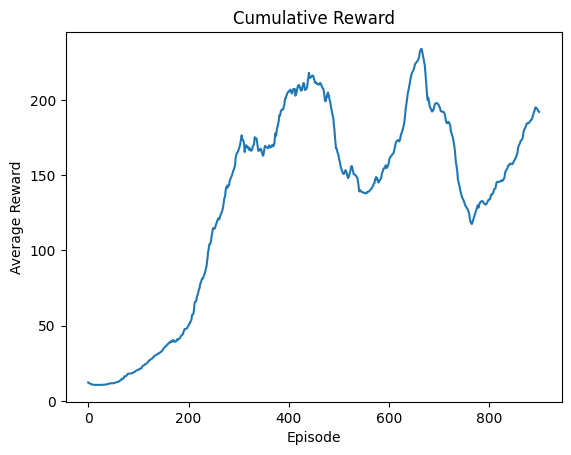

In [11]:
avg_rewards = [np.mean(rewards[i - 100 : i]) for i in range(100, len(rewards))]
plt.plot(avg_rewards)
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.title("Cumulative Reward")
plt.show()

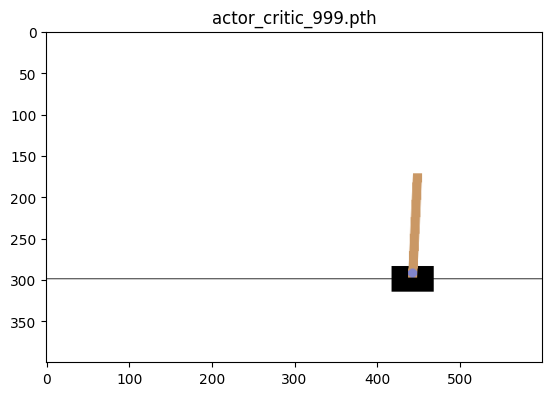

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
from IPython import display

%matplotlib inline

for model_file in sorted(
    list(Path(".").glob("actor_critic_*.pth")), key=lambda x: int(x.stem.split("_")[2])
):
    print(model_file)
    model = ActorCriticNetwork(STATE_SIZE, ACTION_SIZE).to(device)
    model.load_state_dict(torch.load(model_file))
    model.eval()

    env = gym.make("CartPole-v1", render_mode="rgb_array")
    state, _ = env.reset()
    done = False
    img = plt.imshow(env.render())
    plt.title(model_file)
    while not done:
        img.set_data(env.render())
        display.display(plt.gcf())
        display.clear_output(wait=True)

        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        action = torch.argmax(model(state)[0]).item()
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        time.sleep(1 / 60)
    env.close()